In [174]:
samples = 201
f_sampling = 5888
M = (samples - 1) / 2
f_c=5 / (3.2*M - 4.6)
f_cutoff = f_c /2 *f_sampling
print('f_cutoff', f_cutoff, "Hz =", 1/(f_cutoff) *1000, 'ms')
print('200 Hz = 5 ms')
print('fastest movement: about', 1/50 * 1000, 'ms')

f_cutoff 46.6708941027267 Hz = 21.42663043478261 ms
200 Hz = 5 ms
fastest movement: about 20.0 ms


### imports

In [175]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import scipy.signal as signal
import scipy.interpolate as interpolate
import pickle
import glob # find files in a directory
import re # regex for string parsing

### set `folder_name`

In [176]:
name = 'ANB1'
session = '20231030_d5'
num_trials = 183
day = 5

In [177]:
tone_discriminiation_matfile = '../../Data_Copy/ToneDiscrimination/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
Velocity_folder = "../../Data_Copy/AnalysisData/"+name+"/Velocity_"+name+"_"+session+"/"
output_folder = "../../Data_Copy/AnalysisData/"+name+"/Jerk_"+name+"_"+session+"/"

for mac:

In [178]:
!mkdir {output_folder}

The syntax of the command is incorrect.


for windows:

In [179]:
!mkdir "{output_folder}"

A subdirectory or file ../Data_Copy/AnalysisData/ANB1/analysis6_ANB1_20231030_d5/ already exists.


### sort through relevant .mat files found in folder by day ("_d#")

In [180]:
# loop through all movements from that day
for buffered_velocity_file in glob.glob(Velocity_folder+'buffered_velocity_trial*.npy'):
    trial_i = int(re.search(r"(?<=trial).+?(?=\.npy)", buffered_velocity_file).group())
    buffered_velocity_data = np.load(buffered_velocity_file)

    filtered = signal.savgol_filter(buffered_velocity_data[1, :], window_length=501, polyorder=4)
    
    # get the moving average
    buffered_jerk=np.vstack([buffered_velocity_data[0, :], filtered])
    np.save(output_folder+'buffered_jerk_trial'+str(trial_i), buffered_jerk)


In [181]:
# loop through all movements from that day
num_samples = 10*10000
jerks_percent_scaled = np.array([]).reshape((0, num_samples))
for jerk_file in glob.glob(output_folder+'buffered_jerk_trial*.npy'):
    trial_i = int(re.search(r"(?<=trial).+?(?=\.npy)", jerk_file).group())
    jerk = np.load(jerk_file)
    #jerk=jerk[:, 300:-300]

    percent_completion_x = np.linspace(0, 100, jerk.shape[1])
    jerk_fcn = interpolate.interp1d(percent_completion_x, jerk[1, :], kind='linear')
    new_x = np.linspace(0, 100, num_samples)
    new_y = jerk_fcn(new_x)
    jerks_percent_scaled = np.vstack([jerks_percent_scaled, new_y[:]])

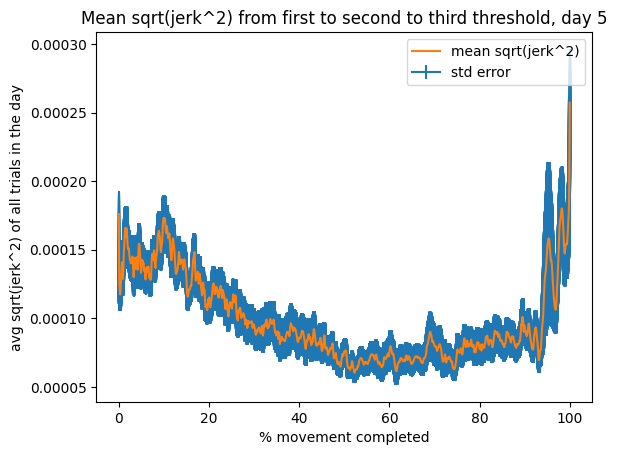

In [182]:
mean_j=np.mean(np.abs(jerks_percent_scaled), axis=0)
var_j=np.var(np.abs(jerks_percent_scaled), axis=0)

x_range = np.array(range(0,num_samples)) * 100 / num_samples
#plt.errorbar(x_range, mean_j, yerr=np.sqrt(var_j), label="std", zorder = 1)
plt.errorbar(x_range, mean_j, yerr=np.sqrt(var_j / len(glob.glob(output_folder+'buffered_jerk_trial*.npy'))), label="std error", zorder = 2)
plt.plot(x_range, mean_j, label="mean sqrt(jerk^2)", zorder = 3)
plt.xlabel("% movement completed")
plt.ylabel("avg sqrt(jerk^2) of all trials in the day")
plt.title("Mean sqrt(jerk^2) from first to second to third threshold, day "+str(day))
#plt.yscale('log')
plt.legend()
plt.show()

### Calculate the minimum jerk